# Project 2: Segmentation and analysis of pelvic bone in CT images
    by Blanca Bastardés Climent

In [165]:
import sys
import os
import numpy as np
import SimpleITK as sitk
from PIL import Image
from pylab import *
import matplotlib.pyplot as plt


In [193]:
# data loading
c_path = 'COMMON_images_masks/'
c_images_list = ['common_40_image.nii.gz','common_41_image.nii.gz','common_42_image.nii.gz']
c_masks_list = ['common_40_mask.nii.gz','common_41_mask.nii.gz','common_42_mask.nii.gz']
g_path = 'GROUP_images'
g_images_list = ['g9_77_image.nii','g9_78_image.nii','g9_79_image.nii']


'COMMON_images_masks/g9_78_image.nii'

In [203]:
c_images = []
c_masks = []
for i in range(len(c_images_list)):
    im = sitk.ReadImage(os.path.join(c_path, c_images_list[i]))
    #c_images.append(sitk.GetArrayFromImage(im))
    c_images.append(im)
    mask = sitk.ReadImage(os.path.join(c_path, c_masks_list[i]))
    #c_masks.append(sitk.GetArrayFromImage(mask))
    c_masks.append(mask)
    
g_images = []
for i in range(len(g_images_list)):
    im_g = sitk.ReadImage(os.path.join(g_path, g_images_list[i]))
    #g_images.append(sitk.GetArrayFromImage(im_g))
    g_images.append(im_g)
    #mask = sitk.ReadImage(os.path.join(g_path, g_masks_list[i]))
    #g_masks.append(sitk.GetArrayFromImage(mask))
    #g_masks.append(mask)

# Task1: Atlas creation

In [195]:
#1 femur derecho
#3 cadera derecha
#femur_40 = zeros(len(c_masks[0]))
femur_40 = np.where(c_masks[0]==1,c_images[0],0)
cadera_40 = np.where(c_masks[0]==3,c_images[0],0)
femur_41 = np.where(c_masks[1]==1,c_images[1],0)
cadera_41 = np.where(c_masks[1]==3,c_images[1],0)
femur_42 = np.where(c_masks[2]==1,c_images[2],0)
cadera_42 = np.where(c_masks[2]==3,c_images[2],0)

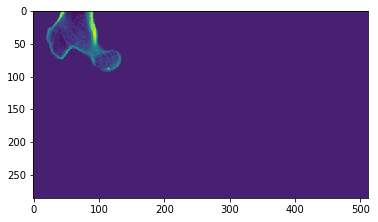

In [198]:
#for i in range(50):
plt.imshow(femur_40[:,237,:])

# Task2:  Linear Registration

In [126]:
def est_lin_transf(im_ref, im_mov):
    """
    Estimate linear transform to align `im_mov` to `im_ref` and return the transform parameters.
    """ 
    
    initial_transform = sitk.CenteredTransformInitializer(im_ref, im_mov, sitk.AffineTransform(3), sitk.CenteredTransformInitializerFilter.GEOMETRY)
    registration_method = sitk.ImageRegistrationMethod()

    # metric
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    
    # use mask to focus on interested regions 
    # registration_method.SetMetricFixedMask(fix_mask)
    
    # interpolator
    registration_method.SetInterpolator(sitk.sitkLinear)
    
    # Gradient descent optimizer
    registration_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()
    
    # set initial transf
    registration_method.SetInitialTransform(initial_transform)

    # perform registration
    final_transform = registration_method.Execute(sitk.Cast(im_ref, sitk.sitkFloat32), 
                                                  sitk.Cast(im_mov, sitk.sitkFloat32))

    
    print(final_transform)
    print("--------")
    print("Optimizer stop condition: {0}".format(registration_method.GetOptimizerStopConditionDescription()))
    print("Number of iterations: {0}".format(registration_method.GetOptimizerIteration()))
    print("--------")
    
    return final_transform

In [147]:
def apply_lin_transf(im_mov, lin_xfm, im_ref):
    """
    Apply given linear transform `lin_xfm` to `im_mov` and return the transformed image.
    """

    resampler = sitk.ResampleImageFilter()             # resample moving image
    resampler.SetReferenceImage(im_ref)                # set the reference image
    resampler.SetInterpolator(sitk.sitkLinear)         # use a linear interpolator
    resampler.SetTransform(lin_xfm)                    # set the desired transformation
    mov_img_resampled = resampler.Execute(im_mov)
    mov_img_resampled_data = sitk.GetArrayFromImage(mov_img_resampled)
    '''
    plt.figure(figsize=(20,50))
    plt.imshow(im_ref, cmap='Blues') # fixed image
    plt.imshow(mov_img_resampled_data, cmap='Reds', alpha=0.3) # mask
    plt.title('Reference image with resampled image')
    '''
    return mov_img_resampled

In [148]:
#this is a test of the linear registration without masks

#im_ref: imagen comun leida
#mov: imagen grupo leida
im_ref = sitk.ReadImage(c_im1, sitk.sitkFloat32)
im_mov = sitk.ReadImage(g_im1, sitk.sitkFloat32)

lin_transform = est_lin_transf(im_ref, im_mov)
mov_img_resampled = apply_lin_transf(im_mov, lin_transform, im_ref)

itk::simple::Transform
 AffineTransform (0x7f9b23a228f0)
   RTTI typeinfo:   itk::AffineTransform<double, 3u>
   Reference Count: 3
   Modified Time: 6067428
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1.00718 0.000367315 0.0164393 
     -0.0210004 0.98273 -0.0484929 
     0.00963012 0.0156269 0.912612 
   Offset: [-16.1429, 296.99, -441.952]
   Center: [1, -129, 842.698]
   Translation: [-2.32973, 258.332, -517.6]
   Inverse: 
     0.993036 -8.66463e-05 -0.0178926 
     0.020686 1.01671 0.0536518 
     -0.010833 -0.0174086 1.09503 
   Singular: 0

--------
Optimizer stop condition: GradientDescentOptimizerv4Template: Maximum number of iterations (100) exceeded.
Number of iterations: 100
--------


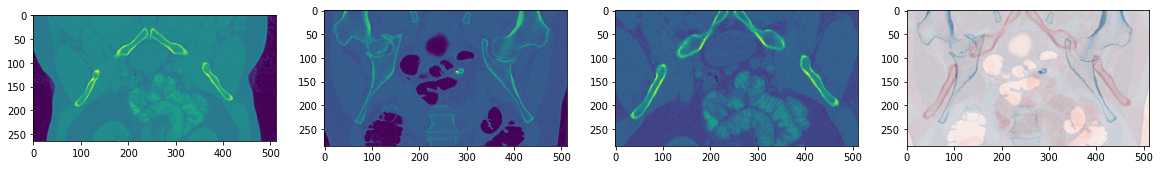

In [153]:
mr = sitk.GetArrayFromImage(mov_img_resampled)
r = sitk.GetArrayFromImage(im_ref)
m = sitk.GetArrayFromImage(im_mov)
plt.figure(figsize=(20,50))
plt.subplot(141)
plt.imshow(m[:,237,:])
plt.subplot(142)
plt.imshow(r[:,237,:])
plt.subplot(143)
plt.imshow(mr[:,237,:])
plt.subplot(144)
plt.imshow(r[:,237,:], cmap='Blues') # fixed image
plt.imshow(mr[:,237,:], cmap='Reds', alpha=0.3) # mask

# Non-linear Registration

In [ ]:
def est_nl_transf(im_ref, im_mov):
    """
    Estimate non-linear transform to align `im_mov` to `im_ref` and return the transform parameters.
    """
    return

In [ ]:
def apply_nl_transf(im_mov, nl_xfm):
    """
    Apply given non-linear transform `nl_xfm` to `im_mov` and return the transformed image.
    """
    return

# Task 3: Atlas based-segmentation

In [ ]:
def seg_atlas(im, atlas_ct_list, atlas_seg_list): 
    """
    Apply atlas-based segmentation of `im` using the list of CT images in `atlas_ct_list` and the corresponding
    segmentation masks in `atlas_seg_list`. Return the resulting segmentation mask after majority voting.
    
    im: reference image (from common)
    atlas_ct_list: list of images to register to im (group ones)
    atlas_seg_list: list of the previous images segmented  
    """
    
    # registration of ct images to the reference one.
    reg_images = []
    for i in range(len(atlas_ct_list))
        lin_transform = est_lin_transf(im, atlas_ct_list[i])
        mov_img_resampled = apply_lin_transf(atlas_seg_list[i], lin_transform, im)
        reg_images.append(sitk.GetArrayFromImage(mov_img_resampled))
        
    # combinations of the registered segmented images (majority voting used) 
    labelForUndecidedPixels = 10
    majority_voting = sitk.LabelVoting(reg_images, labelForUndecidedPixels)
    return majority_voting

In [ ]:
# atlas based-segmentation for the first image (40)
im_ref = sitk.ReadImage(c_im1, sitk.sitkFloat32)
im_mov = sitk.ReadImage(g_im1, sitk.sitkFloat32)

atlas_ct_list = g_images
atlas_seg_list = g_masks

majority_voting = seg_atlas(im_ref, atlas_ct_list, atlas_seg_list)
sitk.WriteImage(majority_vote, "majority_voting.nii")

In [ ]:
# atlas based-segmentation for the three common images
for i in range(len(c_images_list)):
    majority_voting = seg_atlas(c_images[i], atlas_ct_list, atlas_seg_list)
    sitk.WriteImage(majority_vote, "majority_voting_"+c_images[i]+".nii")

# Accuracy assessment